# Колоризация изображений

### Подготовка

Все импорты и функция сид

In [2]:
import os
import random
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Загрузка данных
В качестве данных, на которых проводились эксперименты было взято 8000 изображений из набора данных COCO. Одна эпоха в первой версии эксперимента на моей видеокарте (gtx 1070) занимает около 3-5 минут, поэтому использование большого числа данных привело бы к увеличению времени. Для того чтобы проверить, что наша модель хоть как-то умеет красить 8000 изображений вполне достаточно.

Вообще можно использовать любой понравившийся датасет.

Получить данные можно либо напрямую по ссылке

In [1]:
# !curl -OL https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz

as


Либо через fastai

In [ ]:
!pip install fastai

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
def get_paths(path):

    paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names

    paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
    rand_idxs = np.random.permutation(10_000)
    train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
    val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
    train_paths = paths_subset[train_idxs]
    val_paths = paths_subset[val_idxs]

    return train_paths, val_paths

## Кастомный датасет

Был сделан собственный датасет, чтобы возвращать L канал и отдельно AB каналы в качестве элемента.

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

### Даталоадеры

Здесь по понятно. Просто функция для создания даталоадера

In [ ]:
def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader


## Генератор

Как было рассмотрено в презентации, в качестве генератора хорошо подходит Unet. В первой части экспериментов мы будем работать с собственной реализацией Unet

Идея собственной реализации Unet следующая:

* У нас есть два класса UnetBlock - один из блоков модели и Unet - вся модель
* Блок Unet представляет собой горизонтальное объединение слоев. Это означает то, что блок состоит из 3-х частей: conv слой, внутренний UnetBlock и up conv слой.
* Число каналов и размер входа и выхода у блока UnetBlock равны. Либо можно указать свое число входных каналов (например в начале) и выходных (в конце модели)
* Блок внутри себя сворачивает изображение рекурсивно и разворачивает. Unet архитектура строится путем наращивания блоков, начиная с innermost блока (дно буквы U) и заканчивая outermost блоком, содержащим всю Unet модель

In [1]:
class UnetBlock(nn.Module):

    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        """
        :param nf: число каналов текущего уровня (равно числу каналов выхода  и если не outermost то и входа) / число каналов после up
        :param ni: число каналов на вход внутренниму блоку Unet / число каналов после down
        :param submodule: внутренние блоки
        :param input_c: входные каналы (по умолчанию равно nf)
        :param dropout: нужен ли дропаут
        :param innermost: самый внутренний блок Unet
        :param outermost: Общий блок, содержащий всю сеть
        """
        super().__init__()

        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        """

        :param input_c:  входной канал
        :param output_c: выходной канал
        :param n_down: число слоев вниз
        :param num_filters: размер баового фильтра
        """
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

NameError: name 'nn' is not defined

Посмотрим на получивщуюся модель

In [ ]:
print(Unet())

## Дискриминатор

Дискриминатор представляет собой модель, которая реализована путем объединения блоков Conv-BatchNorm-LeackyReLU. То есть самая простая сверточная сеть

Обратим внимание, что первый и последний блоки не используют нормализацию, а последний блок не имеет функции активации (она встроена в функцию потерь, которую мы будем использовать)

In [3]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        """
        :param input_c: число входных каналов
        :param num_filters: размер начального фильтра
        :param n_down:
        """
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, in_c, out_c, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        """
        :param in_c: входные каналы
        :param out_c: выходные каналы
        :param k: kernel_size
        :param s: stride
        :param p: padding
        :param norm: добавлять ли нормализацию
        :param act: добавлять ли активацию
        :return:
        """
        layers = [nn.Conv2d(in_c, out_c, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(out_c)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Посмотрим на получившуюся модель

In [12]:
print(PatchDiscriminator(input_c=3))

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

В классичиском дискриминаторе выходом модели является только одно число, которое показывает, насколько модель считает все изображение реальным или поддельным. В дискриминаторе патчей, который я использую, модель выводит одно число для каждого патча. Патч это часть входного изображения. В терминах глубокого обучения по сути это поле восприятия. Для каждого из патчей модель решает, поддельный он или нет. Использование такой модели для задачи раскрашивания кажется выгоднее, потому что на определение поддельной раскраски влияют локальные изменения.

In [14]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256)
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

В нашей модели выход получается размером 30 на 30. Воспользовавшись библиотекой https://github.com/Fangyh09/pytorch-receptive-field я посчитал поле восприятия. Получаем, что патч в нашей модели равен 70 на 70

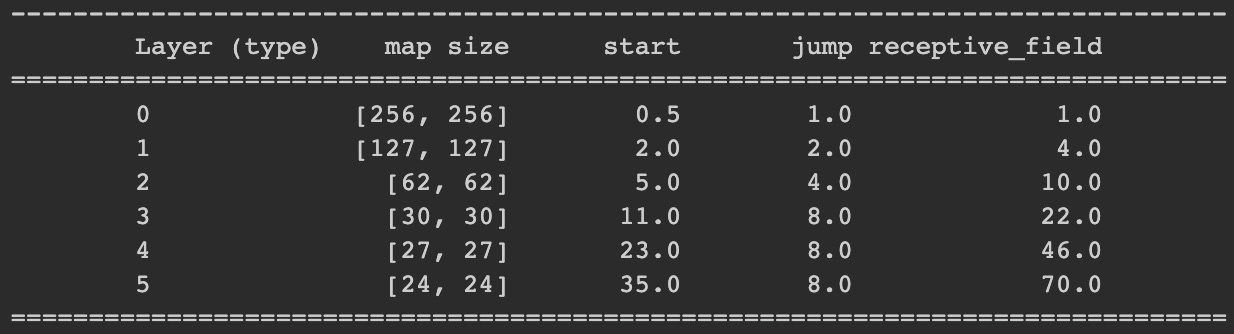

Код работы с данной библиотекой не добавил, так как он не красивый, так как пришлось переписать модель без использования Sequential. Это связано с особенностью библиотеки. Она почему-то не работает с ними

## Функция потерь

Нам нужно чтобы лосс предоставил удобный интерфейс, где в функцию мы передаем только флаг в качестве ожидаемого лейбла

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Инициализация модели

В статьях часто встречается кастомная инициализация весов модели для достижения наилучшего качества. Поэтому решил сохранить ее и у себя

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

## Итоговая модель

Рассмотрим, как будет выглядеть ган

При обучении необходимо вызвать методы `setup_input` и `optimize`. После этого на валидации вызывается метод `validate`

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L) # Предсказание

    def validate(self, data):
        """
        :return: возвращает предсказание и оригинальное изображение разбитое на ab и L
        """
        self.net_G.eval()

        with torch.no_grad():
            self.setup_input(data)
            self.forward()
        self.net_G.train()

        return self.fake_color.detach(), self.ab, self.L

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1) # склеиваем в LAB изображение
        fake_preds = self.net_D(fake_image.detach()) # предсказания по сегментам
        self.loss_D_fake = self.GANcriterion(fake_preds, False) # смотрим на то, насколько хорошо дискриминатор может определить, что подали предсказание с фейковыми цветами
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True) # учим дискриминатор выявлять изображение с реальными цветами
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5 # в статьях потому что эмперически более стабильно
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1) # склеиваем в LAB изображение
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True) # Мы хотим чтобы  дискриминатор был обманут
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1 # попиксельно заставляет быть схожим
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward() # делаем предсказания раскраски
        # Сначала обучаем дискриминатор
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        # После этого обучаем наш генератор
        self.net_G.train()
        # Замораживаем веса дискриминатора, чтобы обучение генераторы не было с ним связано
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## Сбор метрик

Собираем все лоссы в одном месте, чтобы удобно логировать словарем в wandb

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

## Логирование

Для логирования был написан вспомогательный класс, который скрывает под собой обращения к wandb.

Перед его использованием необходимо вызвать код `Logger.prepare("_Название_проекта_")`, чтобы задать имя текущего проекта

После этого создавать экземпляр логгер необходимо с использованием `with Logger(...) as logger`, передав название текущего эксперимента и опционально модель

Данный класс логирует словарь и массив графиков

In [24]:
import wandb

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def get_imgs_fig(lab, fake, real):
    """
    Метод для создания фигуры с изображениями эксперимента
    :param lab: изображение LAB
    :param fake: предсказание
    :param real: оригинальное изображение
    :return: фигура
    """
    fig, axes = plt.subplots(3, 1)

    axes[0].imshow(lab)
    axes[0].axis("off")
    axes[0].set_title('LAB изображение', fontsize = 20)

    axes[1].imshow(fake)
    axes[1].axis("off")
    axes[1].set_title('Раскрашенное', fontsize = 20)

    axes[2].imshow(real)
    axes[2].axis("off")
    axes[2].set_title('Оригинал', fontsize = 20)

    fig.set_size_inches(5, 15)
    plt.close()

    return fig

class Logger:

    project = None

    @staticmethod
    def prepare(project_name):
        """
        Перед использование логгер обязательно нужно запустить данный метод
        :param project_name: название проекта
        """
        wandb.login()
        Logger.project = project_name

    def __init__(self, name, model = None):
        """
        :param name: название текущего эксперимента
        """
        self.name = name
        self.model = model

    def __enter__(self):
        wandb.init(project=self.project, name=self.name)
        if not self.model is None: wandb.watch(self.model)
        return  self

    def __exit__(self, exc_type, exc_val, exc_tb):
        wandb.finish()

    def log_dict(self, dict):
        """
        Логирует словарь
        """
        wandb.log(dict)
    def log_images(self, figs, epoch):
        """
        Логирует массив фигур как изображения
        :param figs: массив фигур
        :param epoch: номер эпохи
        """
        images = list(map(lambda x: wandb.Image(x), figs))
        wandb.log({"Изображения": images}, step = epoch)

## Функция обучения

При обучении будем логировать два раза.
1. После обучения. Будут логироваться значения лоссов
2. После валидации. Логируется батч валидационных картинок. Логируется тройка изображений: ч-б картинка, наша раскраска и оригинальное цветное изображение

In [ ]:
def validate(model, val_dl, epoch, logger):
    data  = next(iter(val_dl))
    fake_color, real_color, L = model.validate(data)
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    # получаем массив графиков с изображениями эксперимента для логирования
    figs = list(map(lambda x: get_imgs_fig(x[2].cpu(), x[0].cpu(), x[1].cpu()), list(zip(fake_imgs, real_imgs, L[:, 0]))))

    logger.log_images(figs, epoch)

def train_model(model, train_dl, val_dl, epochs, logger):

    for e in range(epochs):
        # обнуляем метрики
        loss_meter_dict = create_loss_meters()

        for data in tqdm(train_dl, desc = f"Training, epoch {e}", leave=False):

            # step
            model.setup_input(data)
            model.optimize()

            # обновляем метрики
            update_losses(model, loss_meter_dict, count=data['L'].size(0))

        logger.log_dict({k: v.avg for k, v in loss_meter_dict.items()})
        validate(model, val_dl, e, logger)

## Запуск обучения

In [ ]:
Logger.prepare("Colorization")

seed_everything(42)

train_paths, val_paths = get_paths(coco_path)

train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

model = MainModel()
with Logger(model= model, name= "End") as logger:
    train_model(model, train_dl, val_dl, 100, logger)
torch.save(model.state_dict(), "main_model.pt")

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


## Другая стратегия

Изначально мы брали генератор и дискриминатор и обучали их с нуля одновременно. Но из-за этого мы столкнулись с тем, что "слепой обучает слепого". Чтобы избежать этого, в обучение гана лучше отправить генератор, который уже генерирует не совсем случайный шум. Для этого можно сначала предобучить генератор

При этом мы поменяем и сам генератор. Теперь в качестве основы спуска мы будем использовать предобученную на ImageNet сеть, после чего предобучим наш генератор с L1 loss

В качестве основной предобученной модели для U-net я использую ResNet18, однако самостоятельное построение такой сети является далеко не самой простой задачей. Чтобы не сталкиваться с такой сложной задачей, можно опять воспользоваться fastai.

Функция create_body загружает предварительно обученные веса для ResNet18 и разрезает модель, чтобы удалить последние два слоя (GlobalAveragePooling и линейный слой для задачи классификации ImageNet). Затем DynamicUnet использует эту базу для построения U-Net с необходимыми выходными каналами (в нашем случае 2) и размером изображения 256.

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    """
    Предобучает генератор
    """
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl, desc = f"Training generator, epoch {e}", leave=False):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 20)

torch.save(net_G.state_dict(), "generator.pt")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("generator.pt", map_location=device))

Logger.prepare("Colorization")

seed_everything(42)

train_paths, val_paths = get_paths(coco_path)

train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

model = MainModel(net_G=net_G)
with Logger(model= model, name= "End2") as logger:
    train_model(model, train_dl, val_dl, 100, logger)
torch.save(model.state_dict(), "main_model.pt")